In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.units import units

from plot import (Plot, find_all_events_by_year, 
                  plot_events_by_year, find_event_bound_and_time)
from palettable.scientific.sequential import LaJolla_20, Oleron_9

In [2]:
def create_mask_for_event(event_df, da, size):
    """
    Create a mask for the reanalysis data based on the data points.
    
    Note: This function is written in a recursive way. 
    
    Parameter
    ---------
    event : pd.DataFrame
        stores all the (latitude, longitude) information of the stations
        
    size : int
        1/2 of the size of a grid box
        
    Returns
    -------
    The boolean mask and the masked array. 
    """
    lat, lon = event_df.iloc[0].loc['lat'], event_df.iloc[0].loc['lon']
    west, east = (lon // 0.25) * 0.25 - size, (lon // 0.25) * 0.25 + size
    south, north = (lat // 0.25) * 0.25 - size, (lat // 0.25) * 0.25 + size
    mask = (
        (da.coords['latitude'] >= south) & 
        (da.coords['latitude'] <= north) & 
        (da.coords['longitude'] >= west) & 
        (da.coords['longitude'] <= east)
    )
    if len(event_df) == 1:
        return mask
    return mask | create_mask_for_event(event_df.iloc[1:, :], da, size)
    

In [3]:
year = 1993
year_dir = os.path.join('reanalysis', str(year))

In [4]:
pl_temp_files = glob(os.path.join(year_dir, '*pl_temperature*'))
pl_temp_files.sort()
pl_temp_files

['reanalysis/1993/e5_199311_pl_temperature.nc',
 'reanalysis/1993/e5_199312_pl_temperature.nc',
 'reanalysis/1993/e5_199401_pl_temperature.nc',
 'reanalysis/1993/e5_199402_pl_temperature.nc',
 'reanalysis/1993/e5_199403_pl_temperature.nc']

In [5]:
pl_temp_data = [xr.open_dataset(file) for file in pl_temp_files]
pl_temp_data = xr.concat(pl_temp_data, dim='time')
pl_temp_data

<xarray.Dataset>
Dimensions:    (longitude: 421, latitude: 261, level: 12, time: 1208)
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.8 -144.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 10.5 10.25 10.0
  * level      (level) int32 1000 975 950 925 900 875 850 825 800 775 750 700
  * time       (time) datetime64[ns] 1993-11-01 ... 1994-03-31T21:00:00
Data variables:
    t          (time, level, latitude, longitude) float32 249.5 249.4 ... 281.5
Attributes:
    Conventions:  CF-1.6
    history:      2022-07-02 15:06:02 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [6]:
pl_files = glob(os.path.join(year_dir, '*_pl.nc'))
pl_files.sort()
pl_files

['reanalysis/1993/e5_199311_pl.nc',
 'reanalysis/1993/e5_199312_pl.nc',
 'reanalysis/1993/e5_199401_pl.nc',
 'reanalysis/1993/e5_199402_pl.nc',
 'reanalysis/1993/e5_199403_pl.nc']

In [7]:
pl_data = [xr.open_dataset(file) for file in pl_files]
pl_data = xr.concat(pl_data, dim='time')
pl_data

<xarray.Dataset>
Dimensions:    (longitude: 421, latitude: 261, level: 4, time: 1208)
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.8 -144.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 10.5 10.25 10.0
  * level      (level) int32 925 850 700 500
  * time       (time) datetime64[ns] 1993-11-01 ... 1994-03-31T21:00:00
Data variables:
    d          (time, level, latitude, longitude) float32 -2.898e-06 ... 1.81...
    z          (time, level, latitude, longitude) float32 7.346e+03 ... 5.751...
    pv         (time, level, latitude, longitude) float32 7.675e-07 ... 1.173...
    u          (time, level, latitude, longitude) float32 -11.54 ... -2.151
    v          (time, level, latitude, longitude) float32 2.76 2.743 ... -7.709
    w          (time, level, latitude, longitude) float32 0.03875 ... 0.1032
    vo         (time, level, latitude, longitude) float32 -2.069e-05 ... -8.4...
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-18 17:44:38 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [8]:
sfc_files = glob(os.path.join(year_dir, '*sfc.nc'))
sfc_files.sort()
sfc_files

['reanalysis/1993/e5_199311_sfc.nc',
 'reanalysis/1993/e5_199312_sfc.nc',
 'reanalysis/1993/e5_199401_sfc.nc',
 'reanalysis/1993/e5_199402_sfc.nc',
 'reanalysis/1993/e5_199403_sfc.nc']

In [9]:
sfc_data = [xr.open_dataset(file) for file in sfc_files]
sfc_data = xr.concat(sfc_data, dim='time')
sfc_data

<xarray.Dataset>
Dimensions:    (longitude: 421, latitude: 261, time: 1208)
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.8 -144.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 10.5 10.25 10.0
  * time       (time) datetime64[ns] 1993-11-01 ... 1994-03-31T21:00:00
Data variables:
    u10        (time, latitude, longitude) float32 -9.077 -9.11 ... -8.108
    v10        (time, latitude, longitude) float32 -1.057 -1.057 ... -3.721
    d2m        (time, latitude, longitude) float32 248.2 248.1 ... 292.7 292.6
    t2m        (time, latitude, longitude) float32 250.9 250.8 ... 297.5 297.5
    msl        (time, latitude, longitude) float32 1.024e+05 ... 1.014e+05
    ptype      (time, latitude, longitude) float32 5.0 5.0 5.0 ... 0.0 0.0 1.0
    tcw        (time, latitude, longitude) float32 1.518 1.508 ... 35.49 35.9
    tcwv       (time, latitude, longitude) float32 1.516 1.507 ... 35.45 35.85
    tp         (time, latitude, longitude) float32 7.505e-06 ... 1.182e-05
    p71.162    (time, latitude, longitude) float32 -6.583 -6.583 ... -200.1
    p72.162    (time, latitude, longitude) float32 2.595 2.595 ... -38.92 -32.85
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-16 00:42:54 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [10]:
u_sfc, v_sfc, t_sfc = sfc_data.u10, sfc_data.v10, sfc_data.t2m
u_850, v_850 = pl_data.u.sel(level=850), pl_data.v.sel(level=850)
t_850 = pl_temp_data.t.sel(level=850)

In [11]:
tadv_850 = mpcalc.advection(t_850, u_850, v_850)
tadv_sfc = mpcalc.advection(t_sfc, u_sfc, v_sfc)

/home/hz542/miniconda3/lib/python3.9/site-packages/metpy/xarray.py:1473: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(


In [39]:
tadv_850 * 10e5

<xarray.DataArray (time: 1208, latitude: 261, longitude: 421)>
<Quantity([[[ 3.02595636e+01  2.41964632e+01  2.15321807e+01 ... -1.06028421e-01
   -4.82569042e+00 -1.30208337e+01]
  [ 3.30652156e+01  3.15376326e+01  3.09382222e+01 ... -3.48925943e+01
   -5.52678677e+01 -7.50326102e+01]
  [ 4.04857116e+01  4.06777995e+01  4.15303873e+01 ... -5.46277632e+01
   -8.42809477e+01 -1.04945540e+02]
  ...
  [-1.97772187e+01 -9.64614247e+00 -1.04713377e+01 ... -4.00582989e+00
   -6.90363151e-01  3.26236458e+00]
  [-1.52049835e+01 -2.56829059e+00  2.55073233e+00 ...  1.58814243e+00
    3.49720116e+00  4.83207602e+00]
  [ 1.87916035e+01  1.03602567e+01  1.38974015e+01 ...  1.78038995e+00
    2.28720751e+00  1.28609260e+00]]

 [[ 3.01626517e+01  2.40337911e+01  2.22755076e+01 ...  8.11502240e+01
    7.71246959e+01  7.22160720e+01]
  [ 2.71253844e+01  2.99578830e+01  3.10605113e+01 ...  5.38791577e+01
    3.36005994e+01  1.81404373e+01]
  [ 2.86538098e+01  3.14664266e+01  3.15403006e+01 ...  2.75849376e+01
    7.95867297e+00 -4.29944173e+00]
...
  [-1.95577477e+01 -2.13709983e+01 -2.00131656e+01 ...  4.71124330e+01
    2.81303630e+01  1.21566799e+01]
  [-7.07064946e-01 -1.02450302e+01 -1.23578492e+01 ...  2.52787644e+01
    1.67644074e+01  8.73828011e+00]
  [ 1.04620079e+01 -5.53672637e+00 -7.06583692e+00 ...  8.13792022e+00
    5.93919977e+00  1.08789344e+01]]

 [[-1.23329862e+02 -1.29894368e+02 -1.38408303e+02 ... -7.30346945e+01
   -4.97216271e+01 -3.09266692e+01]
  [-1.20414417e+02 -1.22714088e+02 -1.27105191e+02 ... -7.14124107e+01
   -5.52222160e+01 -4.19914500e+01]
  [-1.31873215e+02 -1.31466682e+02 -1.35949267e+02 ... -7.13265878e+01
   -5.76273229e+01 -4.42653179e+01]
  ...
  [-1.89468040e+01 -9.91895190e+00 -4.44124627e+00 ...  8.52242324e+00
   -4.94863431e+01 -9.68778915e+01]
  [ 4.42646215e+00 -7.60132444e+00 -9.81128050e+00 ... -1.91432852e+01
   -4.22783497e+01 -4.27819221e+01]
  [ 8.77976957e+00 -5.05272064e+00 -7.41362626e+00 ...  7.03945615e+00
    1.14823047e+01  3.26424591e+01]]], 'kelvin / second')>
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.8 -144.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 10.5 10.25 10.0
    level      int32 850
  * time       (time) datetime64[ns] 1993-11-01 ... 1994-03-31T21:00:00

In [13]:
tadv_850_tendency = mpcalc.first_derivative(tadv_850, axis='time')
tadv_sfc_tendency = mpcalc.first_derivative(tadv_sfc, axis='time')

In [38]:
tadv_850_tendency * 10e10

<xarray.DataArray (time: 1208, latitude: 261, longitude: 421)>
<Quantity([[[-4.28365508e+01 -5.48542889e+01 -4.66142421e+01 ...  8.37887093e+02
    8.67208726e+02  9.24275968e+02]
  [-1.59818613e+02 -7.86404722e+01 -4.57838152e+01 ...  8.61365286e+02
    8.86509897e+02  9.98391447e+02]
  [-1.94573220e+02 -1.29328793e+02 -1.25054129e+02 ...  7.83545785e+02
    9.68947526e+02  1.14878836e+03]
  ...
  [ 1.20962307e+01  8.01452821e+01  1.05654385e+02 ...  3.53576872e+00
   -6.56997459e+01 -2.27974810e+02]
  [-2.31992598e+02 -2.47729686e+02 -2.14613447e+02 ...  3.09581100e+02
    1.43211596e+02 -9.34644874e+01]
  [-7.37866715e+02 -5.93136495e+02 -5.38123493e+02 ...  6.41740414e+02
    3.82505172e+02  9.24440576e+01]]

 [[ 4.10418856e+01  5.18418417e+01  6.03795549e+01 ...  6.66858321e+02
    6.50391020e+02  6.54185249e+02]
  [ 4.98217376e+01  4.93858490e+01  4.80484270e+01 ...  7.82556046e+02
    7.59202458e+02  7.27035359e+02]
  [-2.45360742e+01 -4.12521879e+01 -5.99474775e+01 ...  7.38911637e+02
    7.39193598e+02  7.15028261e+02]
...
  [-2.73002945e+02 -9.06457074e+01 -1.50374910e+00 ... -8.60305591e+02
   -9.06071146e+02 -9.03110296e+02]
  [-4.62585618e+02 -1.55372558e+02  3.78456442e+01 ... -9.99707975e+02
   -8.00967154e+02 -4.45227678e+02]
  [-5.72544237e+02 -1.55193824e+02  9.76503491e+01 ... -5.63754749e+02
   -3.28167030e+02 -1.91944768e+01]]

 [[ 3.21652987e+03  3.28292676e+03  3.34082271e+03 ...  6.37879062e+02
    5.25523368e+02  4.01365182e+02]
  [ 2.73596120e+03  2.78240457e+03  2.74304675e+03 ...  8.63290791e+02
    6.32195061e+02  3.81109074e+02]
  [ 2.04056876e+03  2.08201024e+03  2.00320629e+03 ...  7.66292592e+02
    5.07915510e+02  2.68995699e+02]
  ...
  [ 2.84316719e+02  3.02720640e+02  2.89872625e+02 ...  1.45675782e+02
   -5.31275263e+02 -1.11604843e+03]
  [ 5.57650935e+02  2.04330072e+02  9.31303565e+00 ...  1.77077427e+02
   -2.92417235e+02 -5.08850141e+02]
  [ 5.41391675e+02  1.64156893e+02 -1.04090892e+02 ...  5.43412822e+02
    4.30817121e+02  4.22222713e+02]]], 'kelvin / second ** 2')>
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.8 -144.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 10.5 10.25 10.0
    level      int32 850
  * time       (time) datetime64[ns] 1993-11-01 ... 1994-03-31T21:00:00

In [27]:
index = ((tadv_850 - tadv_sfc) * 10e5 * np.exp(-(t_sfc - 273.15)) / 
        ((abs(tadv_850_tendency) + abs(tadv_sfc_tendency)) * 10e10))
index

<xarray.DataArray (time: 1208, latitude: 261, longitude: 421)>
<Quantity([[[ 2.46489190e+09  2.79720233e+09  3.77706078e+09 ... -3.57447517e+10
   -7.46699811e+10 -1.16403578e+11]
  [ 2.94651035e+09  2.93719016e+09  3.04377663e+09 ... -2.60661213e+10
   -2.11602192e+10 -2.59223176e+10]
  [ 3.73073870e+09  4.11126927e+09  3.04136377e+09 ... -7.78804972e+09
   -1.12071700e+10 -1.10494217e+10]
  ...
  [-5.03381305e-13 -4.38493539e-13 -3.52011703e-13 ...  1.02284778e-13
    8.71619448e-14  7.37694113e-15]
  [-2.00021701e-13 -1.17248142e-13 -8.61397573e-14 ...  3.44869694e-14
    7.06020583e-14  8.28057544e-14]
  [ 2.53347559e-13  2.95933512e-13  3.70168974e-13 ...  1.01778881e-14
   -4.44118745e-15 -5.38821166e-16]]

 [[ 5.86103323e+09  7.07381577e+09  9.16019678e+09 ... -2.48383504e+11
   -4.37370085e+11 -6.54759981e+11]
  [ 7.98168712e+09  9.09282981e+09  9.19158219e+09 ... -9.27142704e+10
   -8.01247428e+10 -9.86522770e+10]
  [ 1.37994070e+10  1.64407971e+10  1.08475729e+10 ... -3.42619699e+10
   -3.92489522e+10 -4.06637057e+10]
...
  [-1.55708238e-13 -1.80013711e-13  2.34179455e-13 ...  2.59766968e-12
    2.04222382e-12  1.16651567e-12]
  [-1.47198039e-14 -8.20798705e-14  1.34347089e-14 ...  1.49577609e-12
    1.53917569e-12  1.94496244e-12]
  [ 4.60655522e-14  4.99890512e-14 -2.01244054e-15 ...  1.41963076e-12
    1.68213389e-12  6.75323112e-12]]

 [[-1.21563314e+07 -1.20561116e+07 -1.22358104e+07 ... -2.43160146e+15
   -2.08271281e+15 -1.84692630e+15]
  [-9.43054590e+06 -9.52506009e+06 -1.10976347e+07 ... -1.14154912e+15
   -9.91351242e+14 -9.27291491e+14]
  [-1.28298348e+07 -1.20101276e+07 -1.28461401e+07 ... -6.67560591e+14
   -6.64620618e+14 -6.42091854e+14]
  ...
  [ 5.00607459e-14  1.08924364e-13  2.09921341e-13 ...  4.60979438e-12
   -1.50315788e-12 -2.03487944e-12]
  [ 8.31694488e-14  1.00632687e-13  1.71152800e-13 ...  2.73340212e-13
   -2.06264690e-12 -1.55871749e-12]
  [ 6.56805394e-14  1.29505148e-13  1.09028663e-13 ...  5.89768138e-13
    1.42773881e-12  2.61953735e-12]]], 'second')>
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.8 -144.5 ... -40.5 -40.25 -40.0
  * latitude   (latitude) float32 75.0 74.75 74.5 74.25 ... 10.5 10.25 10.0
    level      int32 850
  * time       (time) datetime64[ns] 1993-11-01 ... 1994-03-31T21:00:00

In [28]:
index = xr.where(index < 0, 0, index)
index = index.reindex(latitude=index.latitude[::-1])

In [29]:
index

Magnitude,[[[2.53347558668528e-13 2.959335116306898e-13 3.7016897390801495e-13 ... 1.0177888120799771e-14 0.0 0.0] [0.0 0.0 0.0 ... 3.4486969414604475e-14 7.060205830840303e-14 8.280575444890285e-14] [0.0 0.0 0.0 ... 1.022847776383387e-13 8.716194484516782e-14 7.376941125813376e-15] ... [3730738704.8371353 4111269273.8287086 3041363774.2849493 ... 0.0 0.0 0.0] [2946510350.089244 2937190161.136275 3043776629.152647 ... 0.0 0.0 0.0] [2464891898.011882 2797202328.429729 3777060783.9806576 ... 0.0 0.0 0.0]] [[0.0 0.0 0.0 ... 8.303123265524152e-14 1.0055929312242621e-13 1.604187426588575e-13] [0.0 0.0 6.001511886165664e-13 ... 2.503797089821053e-14 9.24928576645377e-14 7.856522857078753e-14] [0.0 3.5486582281368383e-13 1.2321270273783093e-12 ... 0.0 0.0 0.0] ... [13799407022.116077 16440797060.406467 10847572945.953642 ... 0.0 0.0 0.0] [7981687122.233622 9092829805.278074 9191582186.075258 ... 0.0 0.0 0.0] [5861033234.913748 7073815774.147033 9160196775.571045 ... 0.0 0.0 0.0]] [[1.7214912848847672e-13 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 1.1712129060933648e-13] [0.0 0.0 6.792142101436078e-14 ... 0.0 3.4398522881417625e-14 0.0] ... [4599217862.826851 8198201451.816761 9226072805.168703 ... 0.0 0.0 0.0] [5489920818.532222 6165976211.651704 6265447623.447897 ... 12803518330.913006 0.0 0.0] [11620021955.317003 9577495562.35643 9517598781.235853 ... 0.0 0.0 0.0]] ... [[9.63789704621527e-13 2.341452940085098e-13 0.0 ... 1.3720361652499437e-11 1.5386275599048503e-11 8.1025665444016e-12] [7.784914652892008e-13 3.3510113904198407e-13 1.1874235998832583e-13 ... 1.3889505115944491e-11 1.478274103072283e-11 1.6475455476899044e-11] [4.888044556550097e-13 3.225139280130965e-13 3.1978355034800273e-13 ... 2.210248001195297e-11 1.7896183428773896e-11 8.56150458458937e-12] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] [[4.606555217285992e-14 4.998905116733689e-14 0.0 ... 1.419630758786922e-12 1.682133893444079e-12 6.753231116203159e-12] [0.0 0.0 1.3434708909052826e-14 ... 1.4957760908460466e-12 1.5391756862401105e-12 1.9449624414287537e-12] [0.0 0.0 2.341794552992224e-13 ... 2.597669679434677e-12 2.0422238187565243e-12 1.1665156732645927e-12] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] [[6.568053938485987e-14 1.2950514828388066e-13 1.0902866339229307e-13 ... 5.897681383408463e-13 1.4277388129486114e-12 2.6195373516782445e-12] [8.316944875294479e-14 1.0063268660900481e-13 1.7115280040646906e-13 ... 2.733402120299845e-13 0.0 0.0] [5.006074585113539e-14 1.0892436365000487e-13 2.099213412000648e-13 ... 4.609794375626387e-12 0.0 0.0] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]]]
Units,second


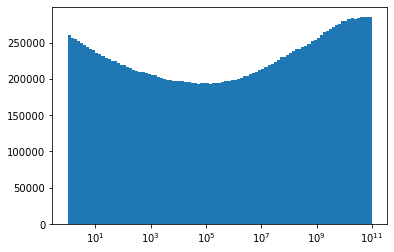

In [30]:
num_bins = 100
bins = np.logspace(0, 11, num_bins)
counts = np.zeros(num_bins - 1, dtype='int64')

for i in index.values.reshape(index.shape[0], -1):
    c, _ = np.histogram(i, bins)
    counts += c
    
fig, ax = plt.subplots()
ax.hist(bins[:-1], bins, weights=counts)
ax.set_xscale('log')
plt.show()

/home/hz542/miniconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


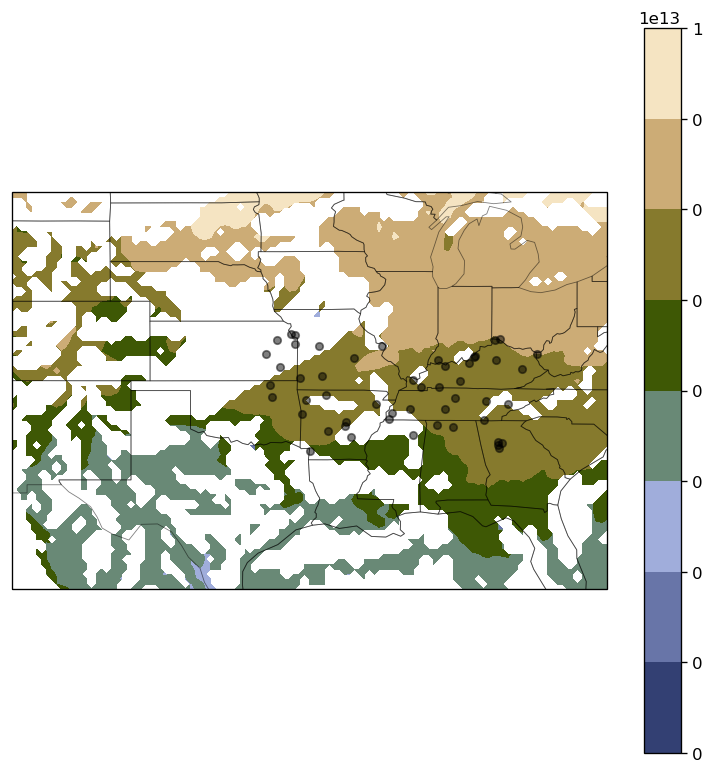

In [51]:
year = 1993
events = find_all_events_by_year(year)
events.sort()
event = events[15]

plot = Plot.from_csv(event)
plot.add_basemap(land=False)

extent, time = plot.extent, plot.time

iindex = (index.interp(time=plot.time)
               .sel(latitude=slice(extent[2], extent[3]))
               .sel(longitude=slice(extent[0], extent[1])))


plot.contourf(iindex, Oleron_9.mpl_colormap, use_log=True)

In [32]:
event_df = pd.read_csv(event)
index_mask = create_mask_for_event(event_df, index, 1.25)

In [33]:
masked_index = xr.where(index_mask, index, np.nan)

In [34]:
masked_index.mean()

<xarray.DataArray ()>
<Quantity(7.97305152e+08, 'second')>
Coordinates:
    level    int32 850

In [35]:
event_df['zr_hours'].mean()

3.673921568627452

In [36]:
for year in range(1979, 2022):
    events = find_all_events_by_year(year)
    for event in events:
        df = pd.read_csv(event)
        df['start_time'] = pd.to_datetime(df['start_time'])
        bound, time = find_event_bound_and_time(df)
        west, east, south, north = bound[0], bound[1], bound[2], bound[3]

In [37]:
from datetime import datetime, timedelta

time = datetime(2007, 3, 31, hour=23) + timedelta(hours=6)
time

datetime.datetime(2007, 4, 1, 5, 0)